In [11]:
#!pip install medmnist

In [52]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import pandas as pd
from torchvision.transforms.functional import to_pil_image
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
import itertools


import medmnist
from medmnist import INFO, Evaluator

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on CPU


In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [5]:
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [21]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [22]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /home/rodrigo/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoi

In [23]:
# visualization

train_dataset.montage(length=1)

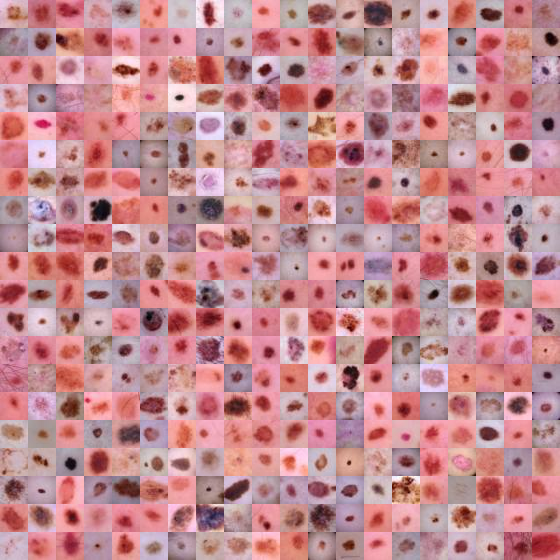

In [24]:
# montage

train_dataset.montage(length=20)

# MLP

### Transform image into vector

#### 1. Flattening

In [48]:
# Stack input features
X_train = torch.stack([sample[0] for sample in train_dataset])
X_val = torch.stack([sample[0] for sample in val_dataset])
X_test = torch.stack([sample[0] for sample in test_dataset])

# Convert labels to 1D tensor
y_train = torch.tensor(train_dataset.labels.squeeze())
y_val = torch.tensor(val_dataset.labels.squeeze())
y_test = torch.tensor(test_dataset.labels.squeeze())

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

#### Get the MLPs

In [38]:
class DNN(nn.Module):

    def __init__(self, input_size, hidden_sizes, num_classes, activation):

        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

            if activation == 'relu':
                self.activations.append(nn.ReLU())
            elif activation == 'sigmoid':
                self.activations.append(nn.Sigmoid())
            elif activation == 'tanh':
                self.activations.append(nn.Tanh())
            else:
                raise ValueError(f"Unknown activation function: {activation}")
        
            for i in range(len(hidden_sizes)-1):

                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

                if activation == 'relu':
                    self.activations.append(nn.ReLU())
                elif activation == 'sigmoid':
                    self.activations.append(nn.Sigmoid())
                elif activation == 'tanh':
                    self.activations.append(nn.Tanh())
                else:
                    raise ValueError(f"Unknown activation function: {activation}")

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):

        for i in range(len(self.activations)):
            x = self.layers[i](x)  # Linear layer
            x = self.activations[i](x)  # Activation function
        
        x = self.layers[-1](x)
        
        return x
    

def fit(X_train, y_train, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=32):
    #send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device)

    # Train the network
    loss_values = []
    for epoch in range(n_epochs):

        accu_loss = 0

        for i in range(0, X_train.size(0), batch_size):

            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = nn(X_batch)
            loss = criterion(outputs, y_batch)
            accu_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, accu_loss))
        loss_values.append(accu_loss)

    return loss_values, nn.to("cpu")


def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    
    return conf_mat


In [50]:
parameters_test = {
    "n_epochs": [50],
    "batch_size": [32, 64],
    "learning_rate": [0.001, 0.01, 0.1],
    "n_layers": [3, 15],
    "activation_function": ['relu', 'sigmoid'],
    "loss_function": [nn.CrossEntropyLoss(), nn.MultiMarginLoss(), nn.MultiLabelSoftMarginLoss()],
    "optimizer": ["ADAM", "SGD", "RMSprop"],
}

# Create a grid of hyperparameters
param_values = [v for v in parameters_test.values()]
param_names = [k for k in parameters_test.keys()]
param_combinations = list(itertools.product(*param_values))

In [ ]:
# dict to store the results

results = {}

# Loop over all hyperparameter combinations
for i, params in enumerate(param_combinations):
    print(f"Testing hyperparameter combination {i+1}/{len(param_combinations)}")
    print(params)

    # Unpack the parameters
    n_epochs, batch_size, learning_rate, n_layers, activation_function, loss_function, optimizer_name = params
    num_inputs = X_train_flattened.shape[1]

    hidden_layers_sizes = ((num_inputs + n_classes) // 2,) * n_layers

    # Define the network
    dnn = DNN(input_size = num_inputs,
              hidden_sizes = hidden_layers_sizes, 
              num_classes = n_classes, 
              activation = activation_function)

    # Define the loss function and optimizer
    criterion = loss_function
    if optimizer_name == "ADAM":
        optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(dnn.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(dnn.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Train the network
    loss_values, trained_net = fit(X_train_flattened, 
                                   y_train, 
                                   dnn,
                                   criterion,
                                   optimizer,
                                   n_epochs = n_epochs, 
                                   batch_size = batch_size, 
                                   to_device = False)

    # Evaluate the network
    conf_mat = evaluate_network(trained_net, X_val_flattened, y_val)

    # Store the results
    results[params] = {
        'loss_values': loss_values,
        'confusion_matrix': conf_mat
    }

    results_df = pd.DataFrame(results)
    results_df.to_csv("results.csv")

Testing hyperparameter combination 1/216
(50, 32, 0.001, 3, 'relu', CrossEntropyLoss(), 'ADAM')


KeyboardInterrupt: 

In [41]:
y_train.ndim

2

In [45]:
train_dataset.labels

array([[0],
       [5],
       [5],
       ...,
       [2],
       [5],
       [5]], shape=(7007, 1), dtype=uint8)